In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as si
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = yf.download("SOL-USD", start="2021-03-31", end="2022-03-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
data['Adj Close'].head()

Date
2021-03-30    19.233925
2021-03-31    19.465229
2021-04-01    19.084902
2021-04-02    19.810223
2021-04-03    22.552277
Name: Adj Close, dtype: float64

In [4]:
data['Adj Close'].tail()

Date
2022-03-26    101.764183
2022-03-27    107.084221
2022-03-28    106.465256
2022-03-29    111.710312
2022-03-30    120.699486
Name: Adj Close, dtype: float64

In [5]:
S = data['Adj Close'][-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ 120.7 .


In [6]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
vol_h = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is 141.66 %


array([<AxesSubplot:xlabel='Date'>], dtype=object)

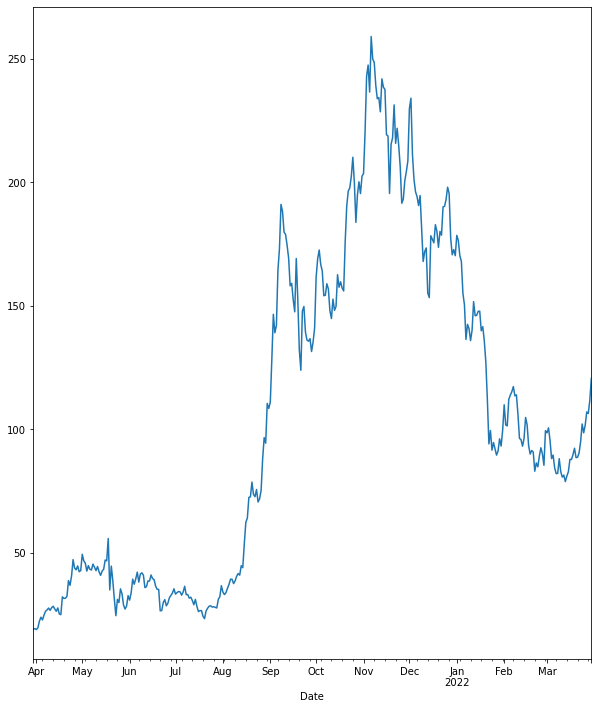

In [7]:
data['Adj Close'].plot(figsize=(10, 12), subplots=True)

# Binomial

In [8]:
import numpy as np
import os

In [9]:
S0 = 120.7             # spot stock price
K = 100.0               # strike
T = 1/12                # maturity 
r = 0.0172              # risk free rate 
sig = 1.41              # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff 

In [10]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [11]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [12]:
S

array([[120.7       , 152.67448839, 193.11929912, 244.27829487],
       [  0.        ,  95.42190155, 120.7       , 152.67448839],
       [  0.        ,   0.        ,  75.43777378,  95.42190155],
       [  0.        ,   0.        ,   0.        ,  59.63890491]])

In [13]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.44252638013730505

In [17]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  4.57809845],
       [ 0.        ,  0.        ,  0.        , 40.36109509]])

In [15]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 8.86867007,  1.42140807,  0.        ,  0.        ],
       [ 0.        , 14.78796031,  2.55095004,  0.        ],
       [ 0.        ,  0.        , 24.51445985,  4.57809845],
       [ 0.        ,  0.        ,  0.        , 40.36109509]])

In [16]:
print('European ' + payoff, str( V[0,0]))

European put 8.86867006790165


# Monte Carlo

In [18]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [20]:
T = 1/12
r = 0.0172
sigma = 1.41
S0 = 120.7
K =140.0

In [21]:
S = mcs_simulation_np(10000)

In [22]:
S = np.transpose(S)
S

array([[120.7       , 120.17425072, 120.21851777, ..., 105.59040121,
        106.01525893, 106.3200795 ],
       [120.7       , 121.28815205, 121.13880417, ...,  70.36755448,
         69.97662783,  70.09911264],
       [120.7       , 119.97122132, 119.63862905, ...,  52.02883026,
         52.15838247,  51.85064473],
       ...,
       [120.7       , 120.49781616, 120.62912961, ..., 225.7527201 ,
        227.03111667, 226.18753696],
       [120.7       , 121.36225254, 121.3363315 , ...,  94.74138047,
         94.76495693,  94.44255242],
       [120.7       , 121.0146759 , 120.7862731 , ..., 116.17048645,
        116.53753387, 116.54257588]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values of SOL-USD')

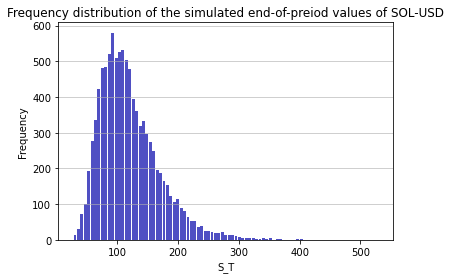

In [23]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values of SOL-USD')

In [24]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 32.04974376149202


In [25]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 12.268373383707079


# Black and Scholes

In [26]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [27]:
S = 120.7
K = 140
T = 1/12
r = 0.0172

In [28]:
call = euro_option_bs(S, K, T, r, vol_h, 'call')
print('The BS call price is', round(call, 2))

The BS call price is 12.88


In [29]:
put = euro_option_bs(S, K, T, r, vol_h, 'put')
print('The BS put price is', round(put, 2))

The BS put price is 31.98


In [62]:
S = np.linspace(60,180,101)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], 130, 1/12, 0.0172, 1.41, 'call')

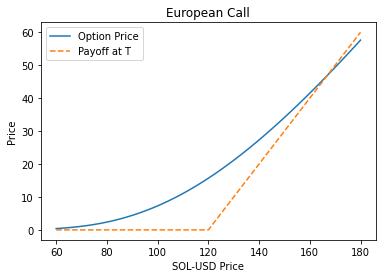

In [63]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-120,0), '--')
plt.xlabel('SOL-USD Price')
plt.ylabel('Price')
plt.title('European Call')
plt.legend(['Option Price','Payoff at T'])

In [60]:
S = np.linspace(60,180,101)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = euro_option_bs(S[i], 110, 1/12, 0.0172, 1.41, 'put')

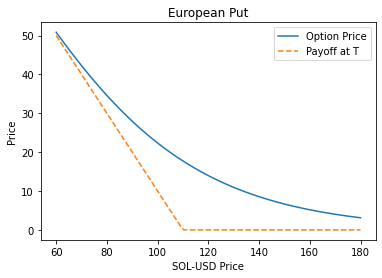

In [61]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.plot(S, np.maximum(110-S,0), '--')
plt.xlabel('SOL-USD Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

# Greeks

In [34]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [40]:
delta(120.7, 140, 1/12, 0.0172, 0, 1.41, 'call')

0.43746806536054883

In [39]:
delta(120.7, 100, 1/12, 0.0172, 0, 1.41, 'put')

-0.25166593200267157

In [58]:
S = np.linspace(60,180,11)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 150, 1/12, 0.0172, 0, 1.41, 'call')
    Delta_Put [i] = delta(S[i], 90, 1/12, 0.0172, 0, 1.41, 'put')

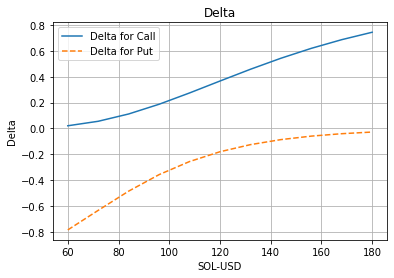

In [59]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('SOL-USD')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [56]:
S = np.linspace(60, 180, 51)
T = np.linspace(0.01, 0.31, 31)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 130, T[i], 0.0172, 0, 1.41, 'call')

C:\Users\AKSHIT~1\AppData\Local\Temp/ipykernel_19972/530771371.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


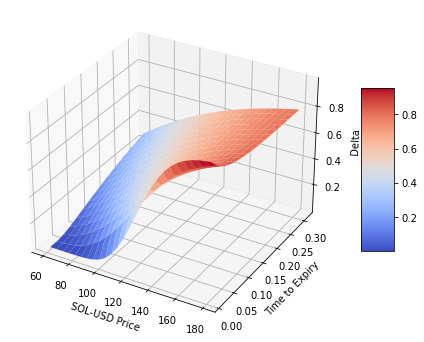

In [57]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('SOL-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma

In [45]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [46]:
gamma(120.7, 130, 1/12, 0.0172, 0, 1.41, 'call')

0.008117869556585154

In [47]:
gamma(120.7, 110, 1/12, 0.0172, 0, 1.41, 'put')

0.0073869675344484945

In [54]:
S = np.linspace(60,180,11)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 130, 1/12, 0.0172, 0, 1.41, 'call')

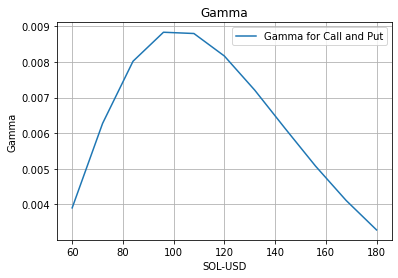

In [55]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('SOL-USD')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

# Surface of Gamma

In [40]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [41]:
S = np.linspace(60, 180, 51)
T = np.linspace(0.5, 2, 51)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 130, T[i], 0.0172, 0, 1.41, 'call')

C:\Users\AKSHIT~1\AppData\Local\Temp/ipykernel_13764/615212430.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


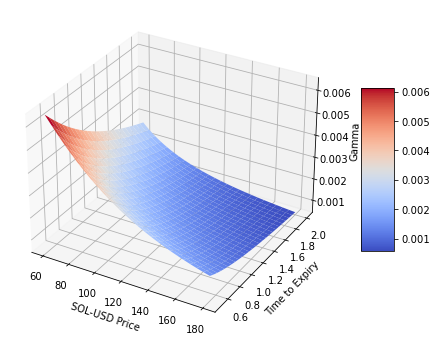

In [42]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('SOL-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Speed

In [8]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [10]:
speed(120.7, 130, 1/12, 0.0172, 0, 1.41, 'call')

-2.0592410262355594e-05

In [12]:
speed(120.7, 110, 1/12, 0.0172, 0, 1.41, 'put')

-3.6552634019836223e-05

In [15]:
S = np.linspace(50,180,11)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 130, 1/12, 0.0172, 0, 1.41, 'call')

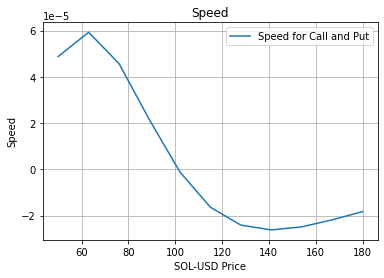

In [16]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('SOL-USD Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

# Surface of Speed

In [17]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [20]:
S = np.linspace(50, 180, 101)
T = np.linspace(0.5, 2, 51)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 130, T[i], 0.0172, 0, 1.41, 'call')

C:\Users\AKSHIT~1\AppData\Local\Temp/ipykernel_13764/53061734.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


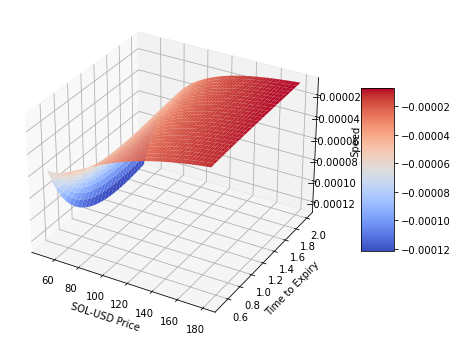

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('SOL-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Theta

In [22]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [23]:
theta(120.7, 130, 1/12, 0.0172, 0, 1.41, 'call')

118.34535751906063

In [24]:
theta(120.7, 110, 1/12, 0.0172, 0, 1.41, 'put')

107.90013600349042

In [26]:
T = np.linspace(1,31,31)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(120.7, 130, T[i], 0.0172, 0, 1.41, 'call')
    Theta_Put [i] = theta(120.7, 110, T[i], 0.0172, 0, 1.41, 'put')

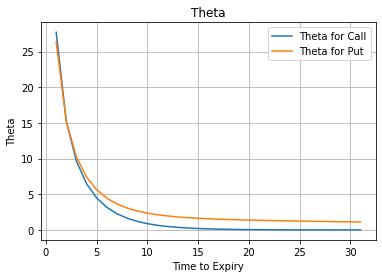

In [27]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

# Surface of Theta

In [28]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [29]:
S = np.linspace(60, 150, 101)
T = np.linspace(1, 31, 31)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 130, T[i], 0.0172, 0, 1.41, 'call')

C:\Users\AKSHIT~1\AppData\Local\Temp/ipykernel_13764/3047530809.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


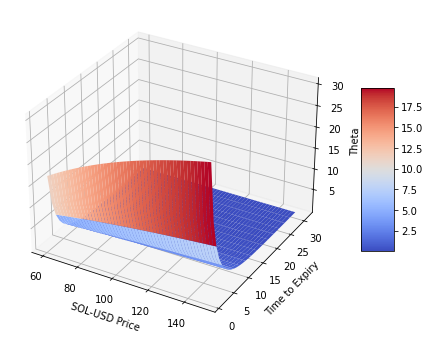

In [30]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('SOL-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Rho

In [31]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [32]:
rho(120.7, 130, 1/12, 0.0172, 0, 1.41, 'call')

3.798127017010953

In [33]:
rho(120.7, 110, 1/12, 0.0172, 0, 1.41, 'put')

-4.474293969746638

In [34]:
r = np.linspace(0,0.1,50)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(120.7, 130, 1/12, r[i], 0, 1.41, 'call')
    Rho_Put [i] = rho(120.7, 110, 1/12, r[i], 0, 1.41, 'put')

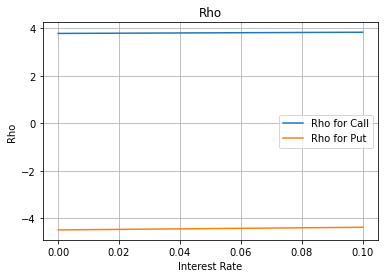

In [35]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

# Surface of Rho

In [36]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [37]:
S = np.linspace(60, 180, 101)
T = np.linspace(0.5, 2, 101)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 130, T[i], 0.0172, 0, 1.41, 'call')

C:\Users\AKSHIT~1\AppData\Local\Temp/ipykernel_13764/2073707530.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


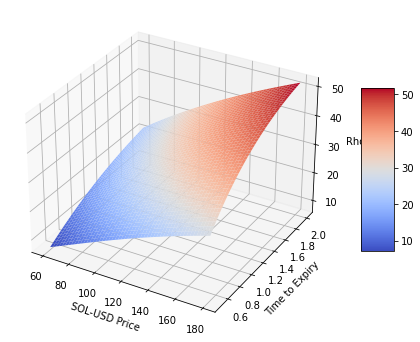

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('SOL-USD Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);